## DTI data processing
`Adam Bernstein`  
`2021-04-15` 

* __The goal is to illustrate diffusion tensor imaging data processing, including the calculation of mean diffusivity (MD) and fractional anisotropy (FA)__
* __The matrix size for data set is $128 \times 128 \times 3 \times 130 $  (in-plane matrix size: 128x128; 3 slices; 130 images with obtained with diffusion encoding schemes shown in bval and bvec)__

In [1]:
push!(LOAD_PATH,"juliafunction");
using PyPlot
using Read_NIfTI1
using DelimitedFiles
using LinearAlgebra
using Statistics

In [2]:
# Load in Diffusion Weighted Images and diffusion weighting information
# DWI
filename = "data/dwi.nii.gz";
headerinfo = load_niigz_header(filename);
dwi = load_niigz_data(filename, headerinfo);

# Brain Mask
filename = "data/mask.nii.gz"
headerinfo = load_niigz_header(filename);
mask = load_niigz_data(filename, headerinfo);

# b-vectors
bvecs = readdlm("data/bvec");

# b-values
bvals = readdlm("data/bval");

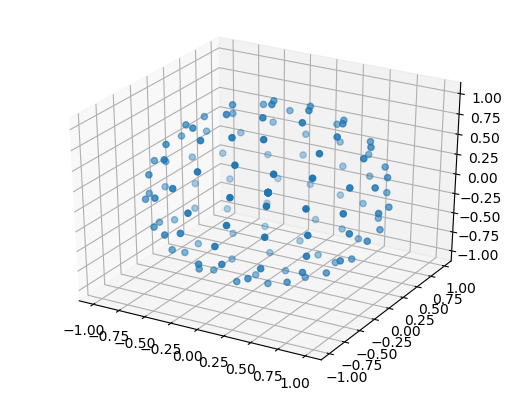

In [3]:
# Display diffusion directions measured
scatter3D(bvecs[1,:], bvecs[2,:], bvecs[3,:]);

In [4]:
# Construct a 'B-Matrix' for linear fitting based on b-values and b-vectors
b_mat = ones(size(dwi)[4],7)
b_mat[:,2] = bvecs[1,:] .^ 2;
b_mat[:,3] = bvecs[2,:] .^ 2;
b_mat[:,4] = bvecs[3,:] .^ 2;
b_mat[:,5] = 2 * bvecs[1,:] .* bvecs[2,:];
b_mat[:,6] = 2 * bvecs[1,:] .* bvecs[3,:];
b_mat[:,7] = 2 * bvecs[2,:] .* bvecs[3,:];

for i = 2:7
    b_mat[:,i] = b_mat[:,i] .* -bvals'
end

# First column of b-matrix is all ones, which is used to fit the b=0 value, especially important when we have multiple b=0 images

In [5]:
# Perform Linear fit for each voxel
eigen_values = zeros(size(dwi)[1], size(dwi)[2], size(dwi)[3], 3);
Tensor = zeros(3,3)
# dwi = log.(dwi)
@time for i = 1:size(dwi)[1]
    for j = 1:size(dwi)[2]
        for k = 1:size(dwi)[3]
            if mask[i,j,k] != 0
                D = b_mat \ log.(dwi[i,j,k,:]);
                Tensor[1,1] = D[2];
                Tensor[1,2] = D[5];
                Tensor[1,3] = D[6];
                Tensor[2,1] = D[5];
                Tensor[2,2] = D[3];
                Tensor[2,3] = D[7];
                Tensor[3,1] = D[6];
                Tensor[3,2] = D[7];
                Tensor[3,3] = D[4];

                # Diagonalize Tensor to get EigenValues
                eigen_values[i,j,k,:] = eigvals(Tensor);
            end
        end
    end
end  

  1.501924 seconds (6.23 M allocations: 1.136 GiB, 6.30% gc time)


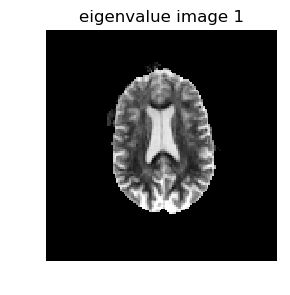

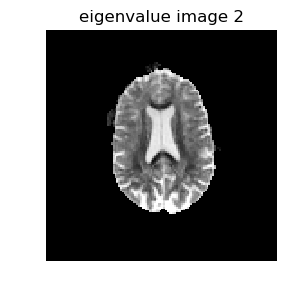

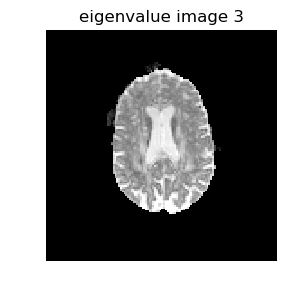

In [6]:
# Display EigenValue Images
figure(1, figsize=(3,3))
imshow(reverse(permutedims(eigen_values[:,:,1,1],[2 1]),dims=1),cmap="gray", vmin=0, vmax=0.001);axis("off"); title("eigenvalue image 1")
figure(2, figsize=(3,3))
imshow(reverse(permutedims(eigen_values[:,:,1,2],[2 1]),dims=1),cmap="gray", vmin=0, vmax=0.001);axis("off");title("eigenvalue image 2")
figure(3, figsize=(3,3))
imshow(reverse(permutedims(eigen_values[:,:,1,3],[2 1]),dims=1),cmap="gray", vmin=0, vmax=0.001);axis("off"); title("eigenvalue image 3");

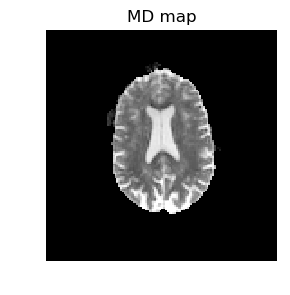

In [7]:
# Calulate MD
MD = mean(eigen_values, dims=4);
figure(1, figsize=(3,3))
imshow(reverse(permutedims(MD[:,:,1],[2 1]),dims=1), cmap="gray", vmin=0, vmax=0.001);axis("off"); title("MD map");

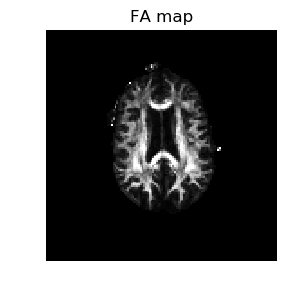

In [8]:
# Calulate FA
numerator = sqrt.((eigen_values[:,:,:,1] - eigen_values[:,:,:,2]) .^ 2 + (eigen_values[:,:,:,2] - eigen_values[:,:,:,3]) .^ 2 + (eigen_values[:,:,:,3] - eigen_values[:,:,:,1]) .^ 2);
denominator = sqrt.(eigen_values[:,:,:,1] .^ 2 + eigen_values[:,:,:,2] .^ 2 + eigen_values[:,:,:,3] .^ 2);

FA = sqrt.(0.5) * numerator ./ denominator;
FA[isnan.(FA)] .= 0;
figure(1,figsize=(3,3))
imshow(reverse(permutedims(FA[:,:,1],[2 1]),dims=1), cmap="gray", vmin=0, vmax=0.7);axis("off");title("FA map");